In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import corner
import matplotlib as mpl

In [2]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
plt.rcParams['font.serif']=cmfont.get_name()
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.size" : 16,#fontsize,
          "text.usetex" : True,
          "mathtext.fontset" : "cm",
          "font.family" : "serif",
          "font.serif" : [cmfont.get_name()],
          "text.latex.preamble" : r"\usepackage{amsmath}"}
plt.rcParams['axes.unicode_minus']=False
plt.rcParams.update(params)

In [3]:
def read_cov(fname):
    cov = np.genfromtxt(fname, delimiter = ',')
    eig, ev = np.linalg.eig(np.linalg.inv(cov))
    
    if not np.all(eig > 0):
        ind = np.where(eig < 0)[0][0]
        eig[ind] = 1e-6
        hes = ev.dot(np.diag(eig).dot(ev.T))
        cov = np.linalg.inv(hes)
        
    return cov


def gen_cov_ck(cov):
    hes = np.linalg.inv(cov)
    hes[[0,1]] = hes[[1,0]]
    hes[:,[0,1]] = hes[:,[1,0]]
    
    inv_cov_ck = np.zeros((9,9))
    inv_cov_ck[:5,:5] = hes[1:6,1:6]
    
    inv_cov_ck[7,:5] = hes[0,1:6]
    inv_cov_ck[:5,7] = hes[0,1:6]
    
    inv_cov_ck[7,8] = hes[0,6]
    inv_cov_ck[8,7] = hes[0,6]
    
    inv_cov_ck[8,:5] = hes[6, 1:6]
    inv_cov_ck[:5,8] = hes[6, 1:6]
    
    inv_cov_ck[7,7] = hes[0,0]
    inv_cov_ck[8,8] = hes[6,6]
    return inv_cov_ck


def dist_err(a, t):
    
    cov = read_cov(f'../data/cov_a{a}_t{t}.csv')
    inv_cov_ck = gen_cov_ck(cov)

    cov_spec = read_cov(f'../data/cov_spec_a{a}_t{t}.csv')#, delimiter = ',')
    
    inv_cov_sp = np.zeros((9,9))
    inv_cov_sp[:7,:7] = np.linalg.inv(cov_spec)
    
    cov_tot = np.linalg.inv(inv_cov_ck + inv_cov_sp)# - np.eye(9)*1e-1)
    return np.sqrt(np.diag(cov_tot))[7]


def dist_err_tau(i):
    
    cov = read_cov(f'../data/cov_ck_a2_t1_plot_{i}.csv')
    inv_cov_ck = gen_cov_ck(cov)

    cov_spec = read_cov(f'../data/cov_spec_a2_t1_plot_{i}.csv')#, delimiter = ',')
    
    inv_cov_sp = np.zeros((9,9))
    inv_cov_sp[:7,:7] = np.linalg.inv(cov_spec)
    
    cov_tot = np.linalg.inv(inv_cov_ck + inv_cov_sp)# - np.eye(9)*1e-1)
    return np.sqrt(np.diag(cov_tot))[7]


def dist_err_n(i):
    
    cov = read_cov(f'../data/cov_n{i}.csv')
    inv_cov_ck = gen_cov_ck(cov)

    cov_spec = read_cov(f'../data/cov_spec_n{i}.csv')#, delimiter = ',')
    
    inv_cov_sp = np.zeros((9,9))
    inv_cov_sp[:7,:7] = np.linalg.inv(cov_spec)
    
    cov_tot = np.linalg.inv(inv_cov_ck + inv_cov_sp)# - np.eye(9)*1e-1)
    return np.sqrt(np.diag(cov_tot))[7]


def dist_err_dec(i):
    
    cov = read_cov(f'../data/cov_dec{i}.csv')
    inv_cov_ck = gen_cov_ck(cov)

    cov_spec = read_cov(f'../data/cov_spec_n0.csv')#, delimiter = ',')
    
    inv_cov_sp = np.zeros((9,9))
    inv_cov_sp[:7,:7] = np.linalg.inv(cov_spec)
    
    cov_tot = np.linalg.inv(inv_cov_ck + inv_cov_sp)# - np.eye(9)*1e-1)
    return np.sqrt(np.diag(cov_tot))[7]

In [4]:
t_ar = np.linspace(0, 90, 9)

d0 = dist_err(0,0)
d2 = [dist_err(2, int(i)) for i in t_ar]
d8 = [dist_err(8, int(i)) for i in t_ar]

d_tau = [dist_err_tau(i) for i in range(1, 4)]
d_n = [dist_err_n(i) for i in range(5)]
d_dec = [dist_err_dec(i) for i in range(6)]

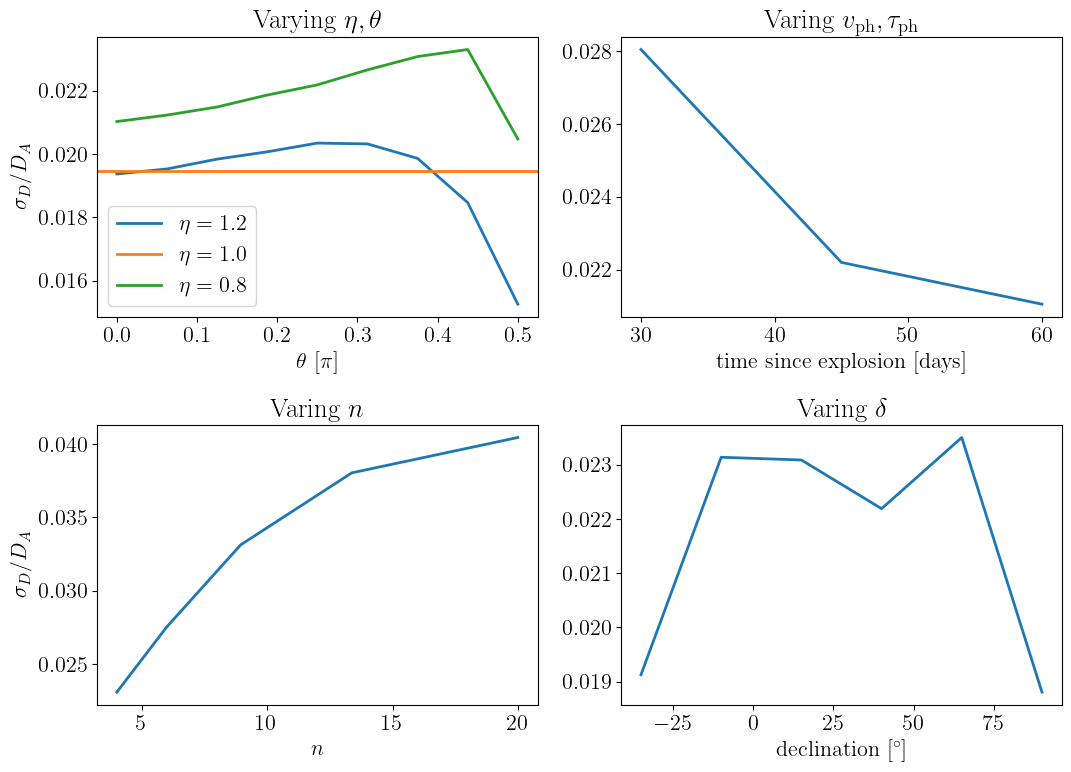

In [5]:
plt.figure(figsize = (11, 8))

plt.subplot(221)
plt.plot(t_ar/180, d2, lw = 2, label = r'$\eta = 1.2$')
plt.axhline(d0, color = 'tab:orange', lw = 2, label = r'$\eta = 1.0$')
plt.plot(t_ar/180, d8, color = 'tab:green', lw = 2, label = r'$\eta = 0.8$')
plt.legend()
plt.xlabel(r'$\theta~[\pi]$')
plt.ylabel(r'$\sigma_D/D_A$')
plt.title(r'Varying $\eta, \theta$')

plt.subplot(222)
plt.plot([30,45,60],d_tau, lw= 2)
plt.xlabel(r'time since explosion [days]')
plt.title(r'Varing $v_\text{ph}, \tau_\text{ph}$') 

plt.subplot(223)
plt.plot(np.logspace(np.log10(4), np.log10(20), 5),d_n, lw= 2)
plt.xlabel(r'$n$')
plt.title(r'Varing $n$') 
plt.ylabel(r'$\sigma_D/D_A$')

plt.subplot(224)
plt.plot(np.arange(90, -40, -25),d_dec, lw= 2)
plt.xlabel(r'declination~$[^\circ]$')
plt.title(r'Varing $\delta$') 

plt.tight_layout()
#plt.savefig('sensitivity.pdf', bbox_inches = 'tight')